# Astroplan What's Up Tutorial

In this tutorial we are going to walk through using Astroplan to find out when the Messier objects will be observable  for a location and time of your choosing. 

## Set up observing location:

In [2]:
from astropy.coordinates import EarthLocation
from astroplan import Observer, FixedTarget

In [3]:
# Where are you observing from:
address = '126 5th Ave, New York, New York, 10010'
timezone = "US/Eastern"

Use the `EarthLocation.of_address()` method to obtain your latitude and longitude. You'll need to have internet access to query Google. Then setup an `Astroplan` observer.

In [4]:
location = EarthLocation.of_address(address)

observer = Observer(location=location, timezone=timezone)

Set up observing time range, minimum altitude constraint, at-night constraint and distance from moon constraint. Note that we use the `time` package here because we can put in a generic time without a full date, as in `astropy.time`.

In [5]:
from astroplan import LocalTimeConstraint, MoonSeparationConstraint, AltitudeConstraint, AtNightConstraint
from datetime import time
import astropy.units as u

# Start and stop observing
start_time = time(20, 0)
end_time = time(2, 0)

# Altitude constraint
minimum_altitude = 30 * u.deg

# Minimum distance from moon: 
minimum_moon_separation = 5 * u.deg

constraints = [LocalTimeConstraint(min=start_time, max=end_time), 
               AltitudeConstraint(min=minimum_altitude), 
               AtNightConstraint.twilight_civil(), 
               MoonSeparationConstraint(min=minimum_moon_separation)]

Here we use `astroplan.utils.time_grid_from_range` to make a grid of times with a one hour resolution to check observability against.

In [6]:
from astropy.time import Time

start_date = Time('2018-05-03')
end_date = Time('2018-05-10')

from astroplan.utils import time_grid_from_range

times = time_grid_from_range([start_date, end_date], time_resolution=1*u.hour)

Load in the `json` dictionary of Messier objects and make a list of `astroplan` targets.  

In [7]:
import json
from astropy.coordinates import SkyCoord, Angle
targets_json = json.load(open('messier_targets.json', 'r'))
targets = []

for target in targets_json:
    coord = SkyCoord(ra=Angle(targets_json[target]['RA'], u.hourangle), dec=Angle(targets_json[target]['DEC'], u.degree))
    targets.append(FixedTarget(coord=coord, name=target))

Use `astroplan.constraint` to return boolean arrays for the grid of times, targets and constraints. The full observability array is the boolean product of them all. 

In [8]:
import numpy as np
observability = np.ones((len(targets), len(times))).astype(bool)

#Loop through constraints
for constraint in constraints: 
    observability &= constraint(observer, targets, times, grid_times_targets=True)

Make a list of object names and V magnitudes. Then make a `pandas` table, through astropy, for easy access.

In [9]:
names = [target.name for target in targets]
vmags = [targets_json[target.name]['V'] for target in targets]

import pandas as pd
from astropy.table import Table

table = Table(rows=[vmags], names=names).to_pandas()

Make a column of start times to use as column names and then label columns and rows. Once we have a `pandas` table we can easily filter out any objects that are never observable with the given constraints.

In [10]:
str_times = [t.iso for t in times]
df = pd.DataFrame(data=observability, columns=str_times, index=names)

filter_out_unobservable_targets = df[df.any(axis=1)]

Here we use the boolean sum to order the rows by the the objects that have the most observable time slots. We make a new column by which to sort, and then delete it when we are done with it. 

In [11]:
sums = np.sum(filter_out_unobservable_targets.as_matrix(), axis=1)

filter_out_unobservable_targets['sum'] = sums

filter_out_unobservable_targets.sort_values('sum', ascending=False)
targets_rm_sum = filter_out_unobservable_targets.drop(columns='sum')

/Users/jeffrey/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Here we filter out the time slots which have no targets observable.

In [12]:
a=targets_rm_sum.any(axis=0)

final_table = targets_rm_sum.loc[:,a.values]

In [13]:
final_table

,2018-05-03 01:00:00.000,2018-05-03 02:00:00.000,2018-05-04 01:00:00.000,2018-05-04 02:00:00.000,2018-05-05 00:59:59.999,2018-05-05 01:59:59.999,2018-05-06 00:59:59.999,2018-05-06 01:59:59.999,2018-05-07 00:59:59.999,2018-05-07 01:59:59.999,2018-05-08 00:59:59.998,2018-05-08 01:59:59.998,2018-05-09 00:59:59.998,2018-05-09 01:59:59.998
M61,True,True,True,True,True,True,True,True,True,True,True,True,True,True
M63,True,True,True,True,True,True,True,True,True,True,True,True,True,True
M95,True,True,True,True,True,True,True,True,True,True,True,True,True,True
M100,True,True,True,True,True,True,True,True,True,True,True,True,True,True
M99,True,True,True,True,True,True,True,True,True,True,True,True,True,True
M104,True,True,True,True,True,True,True,True,True,True,True,True,True,True
M97,True,True,True,True,True,True,True,True,True,True,True,True,True,True
M101,True,True,True,True,True,True,True,True,True,True,True,True,True,True
M109,True,True,True,True,True,True,True,True,True,True,True,True,True,True
M35,True,False,True,False,False,False,False,False,False,False,False,False,False,False


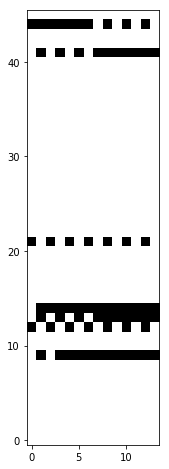

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

#Extent = [times[0].iso,times[-1].iso,M]

plt.figure(figsize=[12,8])
plt.imshow(final_table.as_matrix(),cmap=plt.cm.Greys_r,  origin='lower')
#plt.xlabel('Time from UTC {0} [hrs]'.format(times[0].iso))
plt.show()